Lesson 4

In [ ]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2024-12-07 14:55:30--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap [following]
--2024-12-07 14:55:31--  https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5f0caa68310dadce9cd818490d.dl.dropboxusercontent.com/cd/0/inline/CfzI9y8_wRYS-1ORlk2E65V2jb4_AKFVq4AfQaawNDLzpFUepALOKWeQ1KS7KiQ8O-KwQ8Ok3FfUqxVUb0yD2Pl623cjbuocNHfiqkVMKxLPhZvriR7K0qpTG7GuI3hZcwdlC2T9W7llWpxv6U7-dB0n/file# [following]
--2024-12-07 14:55:31--  https://uc5f0caa68310dadce9cd818490d.dl.dropboxusercontent.com/cd/0/inline/C

In [ ]:
!unzip -q "/content/archive.zip"

In [ ]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
# Creating the Pathlib PATH objects
train_path = Path("/content/train")
test_path = Path("/content/test")

In [ ]:
# Getting Image paths
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
train_image_paths[:10]

['/content/train/disgust/Training_50997276.jpg',
 '/content/train/disgust/Training_73540712.jpg',
 '/content/train/disgust/Training_60623627.jpg',
 '/content/train/disgust/Training_80671795.jpg',
 '/content/train/disgust/Training_14064382.jpg',
 '/content/train/disgust/Training_77446866.jpg',
 '/content/train/disgust/Training_41001987.jpg',
 '/content/train/disgust/Training_8819879.jpg',
 '/content/train/disgust/Training_96544137.jpg',
 '/content/train/disgust/Training_37855272.jpg']

In [ ]:
# Getting their respective labels

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust']

In [ ]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]])

In [ ]:
from sklearn.model_selection import train_test_split

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [ ]:
# Compute class weights

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7991981289675911, 1: 16.671826625387, 2: 1.7243035542747358, 3: 1.0, 4: 1.4471916151572157, 5: 1.4962489580439011, 6: 2.255969836614998}


Lesson 5

In [ ]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
import tensorflow as tf

# Define IMAGE SIZE and BATCH SIZE
IMG_SIZE = 96
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)  # Remove 'experimental'
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Remove 'experimental'
    tf.keras.layers.RandomRotation(0.1),  # Remove 'experimental'
    tf.keras.layers.RandomZoom(height_factor=(-0.1, -0.05))  # Remove 'experimental'
])


In [ ]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 1.76 s, sys: 52.4 ms, total: 1.81 s
Wall time: 3.27 s
(32, 96, 96, 3)
(32, 7)


disgust


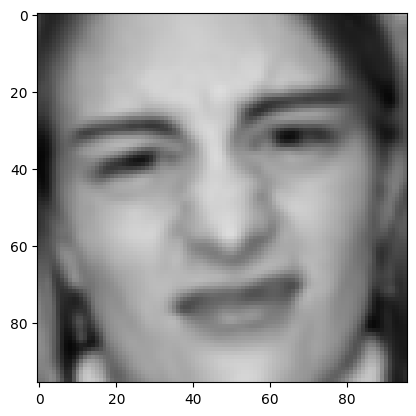

In [ ]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 30.4 ms, sys: 55 µs, total: 30.4 ms
Wall time: 30.3 ms
(32, 96, 96, 3)
(32, 7)


happy


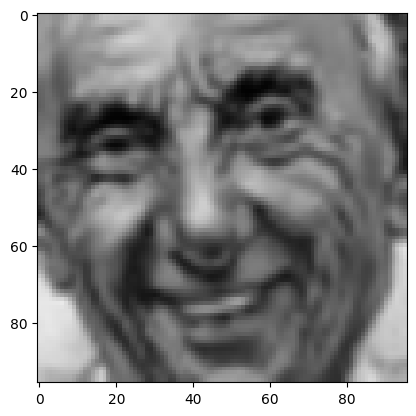

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 3, 3, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,949,824 (30.33 MB)

 Trainable params: 7,882,249 (30.07 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 176s 101ms/step - accuracy: 0.3433 - loss: 3.0546 - precision: 0.5915 - recall: 0.1325 - val_accuracy: 0.3556 - val_loss: 1.8181 - val_precision: 0.4552 - val_recall: 0.2573
Epoch 2/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 129s 100ms/step - accuracy: 0.4810 - loss: 2.4543 - precision: 0.7106 - recall: 0.2677 - val_accuracy: 0.5119 - val_loss: 1.2810 - val_precision: 0.6962 - val_recall: 0.3191
Epoch 3/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 65s 97ms/step - accuracy: 0.5223 - loss: 2.2063 - precision: 0.7116 - recall: 0.3308 - val_accuracy: 0.5476 - val_loss: 1.2595 - val_precision: 0.7595 - val_recall: 0.3004
Epoch 4/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 58s 86ms/step - accuracy: 0.5493 - loss: 2.1025 - precision: 0.7191 - recall: 0.3562 - val_accuracy: 0.5704 - val_loss: 1.1895 - val_precision: 0.7451 - val_recall: 0.3755
Epoch 5/12
672/672 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - accuracy: 0.5574 - loss: 2.0620 - precision: 0.7295 - recall: 0.3673 - val_accuracy: 0.5013 

In [ ]:
model.layers[0].trainable = False

In [ ]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 3, 3, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,714,324 (90.46 MB)

 Trainable params: 181,255 (708.03 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

 Optimizer params: 15,764,500 (60.14 MB)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Testing Phase

In [ ]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.weights.h5",verbose=1,save_best_only=True,save_weights_only = True)

In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

In [ ]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

Save Objects

In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")

In [ ]:
# Save Label Encoder
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")

In [ ]:

import cv2
import numpy as np

# Load the pre-trained model (replace with your model loading code)
# Example:
# model = tf.keras.models.load_model("FacialExpressionModel.h5")
# with open("LabelEncoder.pck", "rb") as f:
#    le = pickle.load(f)

# Placeholder model and label encoder (replace with your actual loaded objects)
class PlaceholderModel:
    def predict(self, image):
        # Replace this with actual prediction
        return np.random.rand(1, 7)

model = PlaceholderModel()
le = LabelEncoder()  # Replace with loaded label encoder

def process_image(frame):
    # Preprocess the frame (resize, normalize) as needed
    resized_frame = cv2.resize(frame, (96, 96))  # Match your model's input size
    normalized_frame = resized_frame / 255.0
    return np.expand_dims(normalized_frame, axis=0)

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Cannot open camera")
    exit()

while True:
    ret, frame = cap.read()

    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    processed_frame = process_image(frame)

    # Make prediction
    prediction = model.predict(processed_frame)

    # Get the predicted label
    predicted_label_index = np.argmax(prediction)
    predicted_label = le.inverse_transform([predicted_label_index])[0]

    # Display the resulting frame
    cv2.putText(frame, predicted_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Facial Expression Recognition', frame)

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# prompt: write a readme notes for this code explaining the steps involved

# Facial Expression Recognition using EfficientNetB2

This README outlines the steps involved in the facial expression recognition project using a pre-trained EfficientNetB2 model.

## Project Setup

1. **Data Download:** The project begins by downloading a dataset (archive.zip) from Dropbox using `wget`.  This dataset contains training and testing images categorized by facial expressions.

2. **Unzip Data:** The downloaded archive is then unzipped using `unzip -q`. The `-q` flag suppresses verbose output.

3. **Import Libraries:** Import all the necessary libraries including TensorFlow, NumPy, Matplotlib, Pathlib, Scikit-learn, OpenCV, and Pickle.

4. **Path Definition:**  Define Pathlib objects for the training and testing image directories.

## Data Preparation

1. **Image and Label Loading:** The script loads the image paths and corresponding labels. Labels are extracted from the directory structure of the images.

2. **Label Encoding:** The labels (facial expressions) are encoded numerically using LabelEncoder from scikit-learn and then one-hot encoded using TensorFlow's `to_categorical`.

3. **Data Splitting:** The dataset is split into training and validation sets using `train_test_split` from scikit-learn.

4. **Class Weight Calculation:** Compute class weights to handle potential class imbalance in the training data. This assigns higher weights to less frequent classes during training.

## Data Augmentation and Preprocessing

1. **Data Loading Function:**  Defines a `load` function to read and decode JPEG images.

2. **Image Resizing:** A Keras `Sequential` model is created to resize images to a fixed size (IMG_SIZE x IMG_SIZE).

3. **Data Augmentation:** Further transformations are applied using data augmentation layers (random flips, rotations, and zoom) to increase the variability of the training data and enhance model robustness.

4. **Dataset Creation:** The `get_dataset` function creates TensorFlow datasets for training and validation. It applies the defined transformations, shuffling, and batching to the images and labels.  This function also includes the option to apply data augmentation during training.

5. **Dataset Verification:** The code verifies the shapes of the image and label tensors from the created datasets to check the correctness of the transformations. Sample images are visualized for verification.

## Model Training

1. **EfficientNetB2 Backbone:** A pre-trained EfficientNetB2 model (without the classification layers) is used as a feature extractor.

2. **Model Architecture:** Build the model by adding Global Average Pooling, Dropout, and dense layers on top of the EfficientNetB2 backbone. The output layer has a softmax activation for multi-class classification.

3. **Model Compilation:** The model is compiled with the Adam optimizer, categorical cross-entropy loss, and evaluation metrics (accuracy, precision, and recall).

4. **Training Phase 1:** The model is trained for a specified number of epochs, using the class weights computed earlier.

5. **Fine-tuning:** The base model (EfficientNetB2) is frozen, and training continues with a set of callbacks (ModelCheckpoint and EarlyStopping) to save the best model weights.

## Model Evaluation and Testing

1. **Test Dataset Preparation:** A dataset is prepared for testing using similar steps of preprocessing and loading as the training and validation sets.

2. **Model Evaluation:** The trained model is loaded with the best weights saved earlier and is evaluated on the test dataset to calculate loss, accuracy, precision, and recall.

3. **Model and Label Encoder Saving:** The trained model and LabelEncoder are saved for later use.

## Real-time Prediction

1. **Model and Label Encoder Loading (example):** The code includes placeholders for loading the saved model and label encoder, so they are ready for use.

2. **Image Preprocessing:**  A `process_image` function is defined to preprocess a single frame of video. This includes resizing and normalization.

3. **Camera Capture and Prediction:** The code captures video from a webcam, processes each frame, and makes a prediction using the loaded model. The predicted facial expression label is displayed on the video stream.

4. **Exit Condition:** The program continues until the key "q" is pressed.